## 인도 철도 일정-가격-가용성 데이터
10-2023년에 IRCTC에서 폐기된 공공 열차를 특징으로 하는 포괄적인 데이터 세트

In [1]:
#conda install python-graphviz

Channels:
 - conda-forge
 - apple
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import Image
import graphviz

In [3]:
df = pd.read_csv('/Users/leejieun/kaggle-notebooks/datasets/bhavyarajdev/indian-railways-schedule-prices-availability-data/price_data.csv')

In [4]:
df.head()

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,totalFare,availability,trainNumber,timeStamp,fromStnCode,toStnCode,classCode,distance,duration
0,1059,60,0,0.0,0,0,56.0,0,0,0,1175,"[{'date': '2-12-2023', 'status': 'AVAILABLE-00...",11464,2023-10-03 22:13:07.781307,JBP,SRID,1A,54,33.0
1,626,50,0,0.0,0,0,34.0,0,0,0,710,"[{'date': '2-12-2023', 'status': 'AVAILABLE-00...",11464,2023-10-03 22:13:07.781307,JBP,SRID,2A,54,33.0
2,441,40,0,0.0,0,0,24.0,0,0,0,505,"[{'date': '2-12-2023', 'status': 'AVAILABLE-01...",11464,2023-10-03 22:13:07.781307,JBP,SRID,3A,54,33.0
3,125,20,0,0.0,0,0,0.0,0,0,0,145,"[{'date': '2-12-2023', 'status': 'AVAILABLE-00...",11464,2023-10-03 22:13:07.781307,JBP,SRID,SL,54,33.0
4,1059,60,0,0.0,0,0,56.0,0,0,0,1175,"[{'date': '2-12-2023', 'status': 'AVAILABLE-00...",11464,2023-10-03 22:13:07.781307,JBP,KKB,1A,69,49.0


In [5]:
df.columns

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'fuelAmount',
       'totalConcession', 'tatkalFare', 'serviceTax', 'otherCharge',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'timeStamp', 'fromStnCode', 'toStnCode', 'classCode',
       'distance', 'duration'],
      dtype='object')

In [6]:
df.drop(['fuelAmount', 'totalConcession','tatkalFare', 'otherCharge'], axis=1, inplace=True)

In [7]:
df_res = df.groupby(['classCode', 'reservationCharge'])['totalFare'].count()
lst_res = df_res.index.to_list()
df_res

classCode  reservationCharge
1A         20                     388
           60                   36763
2A         50                   83630
           60                     389
2S         15                    9398
3A         40                   88049
           50                     389
CC         40                   10136
SL         20                   97113
           40                     388
Name: totalFare, dtype: int64

In [8]:
df_sup = df[df.superfastCharge>0].groupby(['trainNumber', 'classCode', 'superfastCharge'])['totalFare'].count()
lst_sup = df_sup.index.to_list()
df_sup

trainNumber  classCode  superfastCharge
1127         2A         45                  41
             3A         45                  41
             SL         30                  41
1128         2A         45                  99
             3A         45                  99
                                          ... 
22644        3A         45                 455
             SL         30                 455
22645        2A         45                 272
             3A         45                 272
             SL         30                 272
Name: totalFare, Length: 1021, dtype: int64

In [9]:
df['fare_to_predict'] = df.totalFare-df.reservationCharge-df.superfastCharge

In [10]:
df['if_offering_catering'] = df.cateringCharge>0
df['if_dynamic_fare'] = df.dynamicFare>0

In [11]:
df.columns

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'serviceTax',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'timeStamp', 'fromStnCode', 'toStnCode', 'classCode',
       'distance', 'duration', 'fare_to_predict', 'if_offering_catering',
       'if_dynamic_fare'],
      dtype='object')

In [12]:
df_now = df[['classCode', 'if_offering_catering', 'if_dynamic_fare', 'distance', 'duration']]
y = df.fare_to_predict

In [13]:
dummies = pd.get_dummies(df_now['classCode'])
merged = pd.concat([df_now, dummies], axis='columns')
X = merged.drop(['classCode'], axis='columns')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lst = X_test.index.tolist()

In [15]:
X_train.columns

Index(['if_offering_catering', 'if_dynamic_fare', 'distance', 'duration', '1A',
       '2A', '2S', '3A', 'CC', 'SL'],
      dtype='object')

In [16]:
idxs = X_train.index.tolist()
np.random.shuffle(idxs)
X_train = X_train.loc[idxs]
y_train = y_train.loc[idxs]

In [17]:
model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {
            'alpha': [.01, 0.1, 1, 10],
            'fit_intercept': [True, False],
        }
    },
    'decision_tree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 20, 30],
            'max_leaf_nodes': [10, 50, 100],
        }
    },
    'random_forest_regression': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20, 30]
        }
    },
    'gradient_boosting_regression': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    },
    'support_vector_regression': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2]
        }
    }
}

In [18]:
scores = []
for i, (model_name, mp) in enumerate(model_params.items()):
    print(f"Running {i+1}/{len(model_params)}")
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_iter=5)
    if i>2:
        clf.fit(X_train[:1000], y_train[:1000])
    else:
        clf.fit(X_train, y_train)
    # joblib.dump(clf.best_estimator_, f"trained_models/{model_name}.pkl")

    split_scores = []
    for split in range(clf.cv):
        split_scores.append(clf.cv_results_[f'split{split}_test_score'][clf.best_index_])
    scores.append({
        'model': model_name,
        'split_scores': split_scores,
        'best_score': pd.Series(split_scores).mean(),
        'best_params': clf.best_params_,
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.sort_values('best_score', inplace=True)

Running 1/6


/Users/leejieun/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running 2/6
Running 3/6
Running 4/6
Running 5/6
Running 6/6


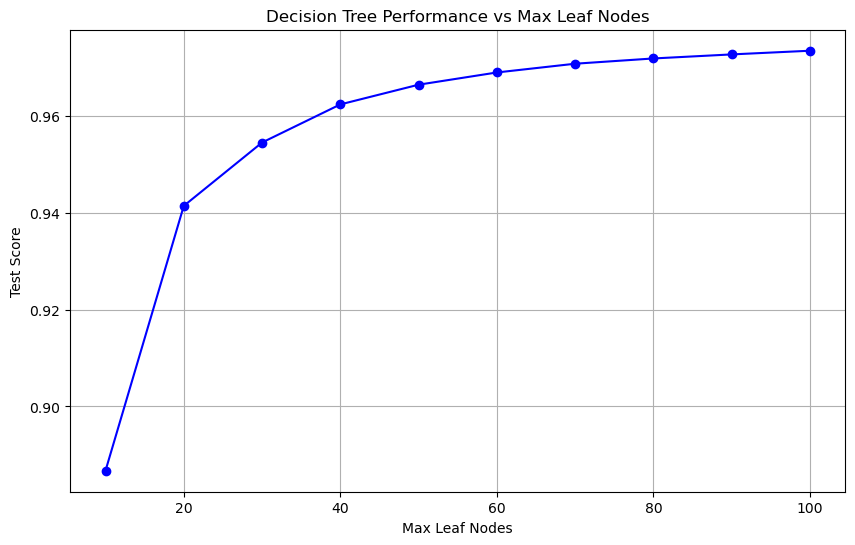

In [19]:
max_leaf_nodes = list(range(10, 101, 10))
dt_models = []
test_scores = []
for leaf_nodes in max_leaf_nodes:
    model = DecisionTreeRegressor(max_leaf_nodes=leaf_nodes)
    model.fit(X_train, y_train)
    dt_models.append(model)
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(max_leaf_nodes, test_scores, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Performance vs Max Leaf Nodes')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Test Score')
plt.grid(True)

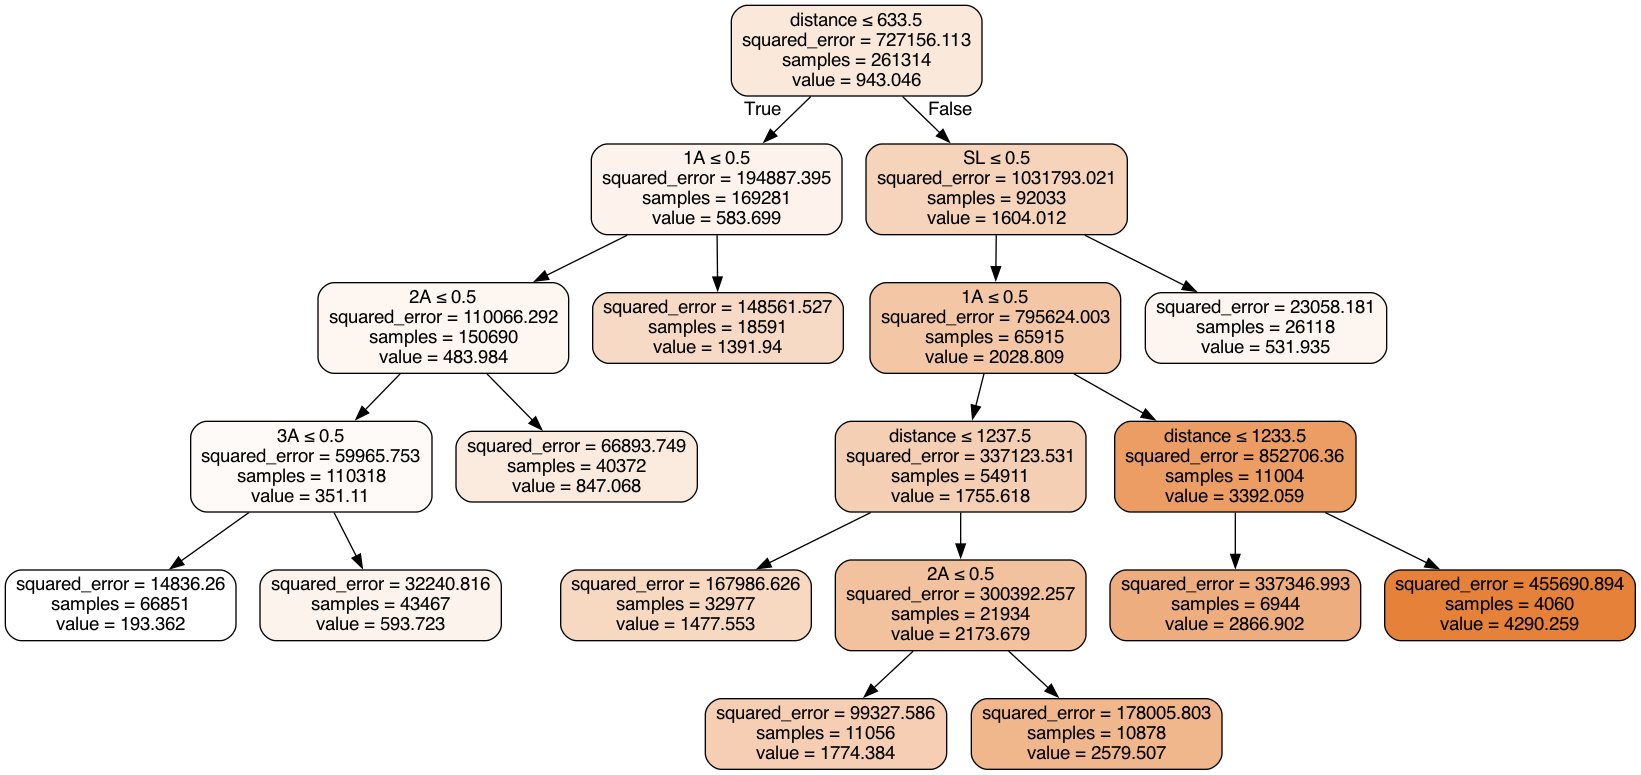

In [20]:
model = DecisionTreeRegressor(max_leaf_nodes=10)
model.fit(X_train, y_train)

dot_data = export_graphviz(model, out_file=None,
                          feature_names=dt_models[0].feature_names_in_,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("small_dt", format="png")
Image('small_dt.png')

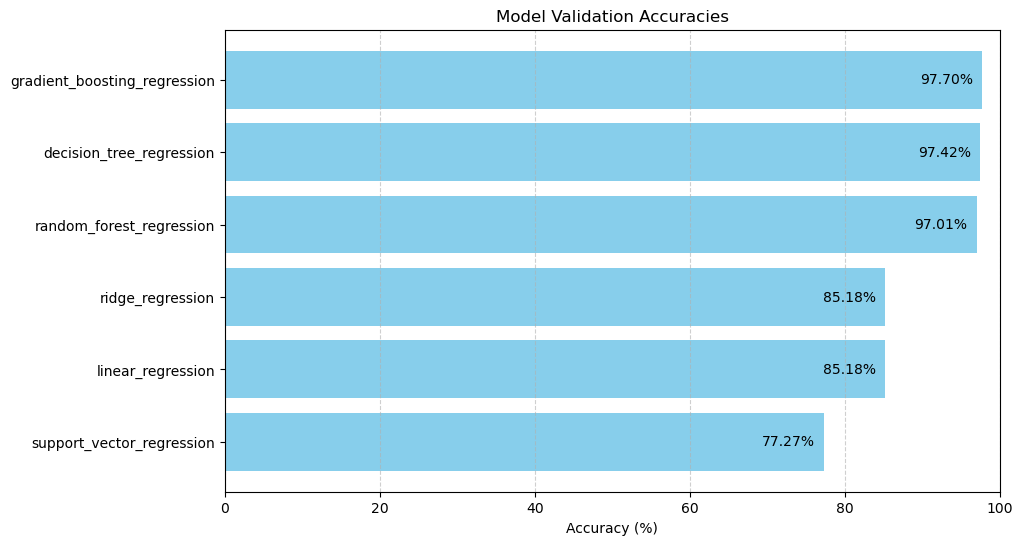

In [25]:
plt.figure(figsize=(10,6))
bars = plt.barh(df.model, df.best_score*100, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Model Validation Accuracies')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar, acc in zip(bars, df.best_score*100):
    plt.text(bar.get_width() - 8, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', color='black', va='center')

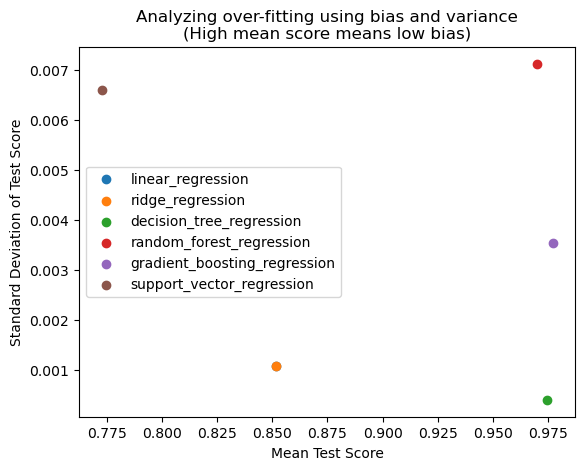

In [27]:
plt.xlabel('Mean Test Score')
plt.ylabel('Standard Deviation of Test Score')
plt.title('Analyzing over-fitting using bias and variance\n(High mean score means low bias)')
for score_d in scores:
    ser = pd.Series(score_d['split_scores'])
    plt.scatter(ser.mean(), ser.std(), label=score_d['model'])
plt.legend()